# Getting started

Once you've chosen your scenario, download the data from [the Iowa website](https://data.iowa.gov/Economy/Iowa-Liquor-Sales/m3tr-qhgy) in csv format. Start by loading the data with pandas. You may need to parse the date columns appropriately.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels as sm
%matplotlib inline
from scipy.stats import mode
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import cross_val_predict
from sklearn.metrics import r2_score

## Load the data into a DataFrame
df = pd.read_csv('/Users/michael/DSI-projects/project-03/assets/Iowa_Liquor_Sales_reduced.csv')

## Transform the dates if needed, e.g.
df['Date'] = pd.to_datetime(df['Date'], format = '%m/%d/%Y')

/Users/michael/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
# check missing values
df.isnull().values.any()

# print out rows contain missing data
null_data = df[df.isnull().any(axis=1)]
# len(null_data)

# take a closer look at the missing data
# null_data.info()


In [3]:
def dolflo(x):
    y = x.split('$')
    return float(y[1])
def integerize(x):
    y = int(x)
    return y

df['Sale (Dollars)'] = df['Sale (Dollars)'].apply(lambda x: dolflo(x))
df['State Bottle Retail'] = df['State Bottle Retail'].apply(lambda x: dolflo(x))
df['State Bottle Cost'] = df['State Bottle Cost'].apply(lambda x: dolflo(x))
df['Sale (Dollars)'] = df['Sale (Dollars)'].round(2)
df['Bottle Markup'] = df['State Bottle Retail'] - df['State Bottle Cost'] 
df['Total Markup'] = df['Bottle Markup'] * df['Bottles Sold']
df['City'] = df['City'].apply(lambda x: x.upper())
df.dropna(inplace=True)
df = df[df['Bottle Volume (ml)']<170000]
df = df[df['Bottle Volume (ml)']>1]

In [4]:
indexdf = df.drop('Item Number',1)
indexdf = indexdf.drop('Item Description',1)
indexdf = indexdf.drop('Bottle Volume (ml)',1)
indexdf = indexdf.drop('Category Name',1)
indexdf = indexdf.drop('Category',1)
indexdf = indexdf.drop('Bottle Markup',1)
indexdf = indexdf.drop('State Bottle Cost',1)
indexdf = indexdf.drop('State Bottle Retail',1)
indexdf = indexdf.drop('Volume Sold (Gallons)',1)

In [5]:
indexdf2015 = pd.DataFrame(indexdf[indexdf['Date']<'2016-01-01'])
indexdf2016 = pd.DataFrame(indexdf[indexdf['Date']>='2016-01-01'])
indexdfq12015 = pd.DataFrame(indexdf[indexdf['Date']<='2015-03-31'])
indexdfq22015 = pd.DataFrame(indexdf[(indexdf['Date']>'2015-03-31') & (indexdf['Date']<='2015-06-30')])
indexdfq32015 = pd.DataFrame(indexdf[(indexdf['Date']>'2015-06-30') & (indexdf['Date']<='2015-09-30')])
indexdfq42015 = pd.DataFrame(indexdf[(indexdf['Date']>'2015-09-30') & (indexdf['Date']<='2015-12-31')])
indexdfnotq12015 = pd.DataFrame(indexdf[(indexdf['Date']>'2015-03-31') & (indexdf['Date']<='2015-12-31')])

In [6]:
testingdf = pd.DataFrame(indexdf[indexdf['County']=='Polk'])
print(testingdf['City'].unique())

['DES MOINES' 'ANKENY' 'URBANDALE' 'JOHNSTON' 'WEST DES MOINES'
 'WINDSOR HEIGHTS' 'PLEASANT HILL' 'ALTOONA' 'GRIMES' 'POLK CITY' 'CLIVE'
 'BONDURANT' 'CAMBRIDGE']


In [7]:
maindf = pd.pivot_table(indexdf,index=['County'],values=['Sale (Dollars)','Bottles Sold','Volume Sold (Liters)','Total Markup'],aggfunc=lambda x: sum(x))
maindf = maindf.sort_values(by='Sale (Dollars)')
maindf = maindf.reset_index(drop=False)
maindf['Bottle Markup'] = maindf['Total Markup']/maindf ['Bottles Sold']

storesdf = pd.pivot_table(indexdf,index=['County'],values=['Store Number'],aggfunc=lambda x: len(x.unique()))
storesdf = storesdf.rename(columns = {'Store Number':'Number of Stores'})
storesdf = storesdf.sort_values(by = ['Number of Stores'])
storesdf = storesdf.reset_index(drop=False)

maindf = pd.merge(maindf, storesdf, on='County', how='inner')
maindf['SalesPerStore']=maindf['Sale (Dollars)']/maindf['Number of Stores']

In [8]:
maindf.head(2)

,County,Bottles Sold,Sale (Dollars),Total Markup,Volume Sold (Liters),Bottle Markup,Number of Stores,SalesPerStore
0,Fremont,3088,29757.10,9940.24,2115.05,3.218990,1,29757.10
1,Davis,9423,116875.92,39078.06,9715.75,4.147093,1,116875.92


In [9]:
testq12015df = pd.pivot_table(indexdfq12015,index=['County'],values=['Sale (Dollars)','Bottles Sold','Volume Sold (Liters)','Total Markup'],aggfunc=lambda x: sum(x))
testq12015df = testq12015df.sort_values(by='Sale (Dollars)')
testq12015df = testq12015df.reset_index(drop=False)
testq12015df['Bottle Markup'] = testq12015df['Total Markup']/testq12015df ['Bottles Sold']

storesq12015df = pd.pivot_table(indexdfq12015,index=['County'],values=['Store Number'],aggfunc=lambda x: len(x.unique()))
storesq12015df = storesq12015df.rename(columns = {'Store Number':'Number of Stores'})
storesq12015df = storesq12015df.sort_values(by = ['Number of Stores'])
storesq12015df = storesq12015df.reset_index(drop=False)

testq12015df = pd.merge(testq12015df, storesq12015df, on='County', how='inner')
testq12015df['SalesPerStore']=testq12015df['Sale (Dollars)']/testq12015df['Number of Stores']

In [10]:
testnotq12015df = pd.pivot_table(indexdfnotq12015,index=['County'],values=['Sale (Dollars)','Bottles Sold','Volume Sold (Liters)','Total Markup'],aggfunc=lambda x: sum(x))
testnotq12015df = testnotq12015df.sort_values(by='Sale (Dollars)')
testnotq12015df = testnotq12015df.reset_index(drop=False)
testnotq12015df['Bottle Markup'] = testnotq12015df['Total Markup']/testnotq12015df ['Bottles Sold']

storesnotq12015df = pd.pivot_table(indexdfq12015,index=['County'],values=['Store Number'],aggfunc=lambda x: len(x.unique()))
storesnotq12015df = storesnotq12015df.rename(columns = {'Store Number':'Number of Stores'})
storesnotq12015df = storesnotq12015df.sort_values(by = ['Number of Stores'])
storesnotq12015df = storesnotq12015df.reset_index(drop=False)

testnotq12015df = pd.merge(testnotq12015df, storesnotq12015df, on='County', how='inner')
testnotq12015df['SalesPerStore']=testnotq12015df['Sale (Dollars)']/testnotq12015df['Number of Stores']

In [11]:
test2015df = pd.pivot_table(indexdf2015,index=['County'],values=['Sale (Dollars)','Bottles Sold','Volume Sold (Liters)','Total Markup'],aggfunc=lambda x: sum(x))
test2015df = test2015df.sort_values(by='Sale (Dollars)')
test2015df = test2015df.reset_index(drop=False)
test2015df['Bottle Markup'] = test2015df['Total Markup']/test2015df ['Bottles Sold']

stores2015df = pd.pivot_table(indexdf2015,index=['County'],values=['Store Number'],aggfunc=lambda x: len(x.unique()))
stores2015df = stores2015df.rename(columns = {'Store Number':'Number of Stores'})
stores2015df = stores2015df.sort_values(by = ['Number of Stores'])
stores2015df = stores2015df.reset_index(drop=False)

test2015df = pd.merge(test2015df, storesq12015df, on='County', how='inner')
test2015df['SalesPerStore']=test2015df['Sale (Dollars)']/test2015df['Number of Stores']

In [12]:
test2016df = pd.pivot_table(indexdf2016,index=['County'],values=['Sale (Dollars)','Bottles Sold','Volume Sold (Liters)','Total Markup'],aggfunc=lambda x: sum(x))
test2016df = test2016df.sort_values(by='Sale (Dollars)')
test2016df = test2016df.reset_index(drop=False)
test2016df['Bottle Markup'] = test2016df['Total Markup']/test2016df ['Bottles Sold']

stores2016df = pd.pivot_table(indexdf2016,index=['County'],values=['Store Number'],aggfunc=lambda x: len(x.unique()))
stores2016df = stores2016df.rename(columns = {'Store Number':'Number of Stores'})
stores2016df = stores2016df.sort_values(by = ['Number of Stores'])
stores2016df = stores2016df.reset_index(drop=False)

test2016df = pd.merge(test2016df, storesq12015df, on='County', how='inner')
test2016df['SalesPerStore']=test2016df['Sale (Dollars)']/test2016df['Number of Stores']

In [65]:
summarydf = test2016df[['County','Sale (Dollars)', 'Bottles Sold', 'Total Markup','Bottle Markup','Number of Stores']]

In [66]:
summarydf.head(2)

,County,Sale (Dollars),Bottles Sold,Total Markup,Bottle Markup,Number of Stores
0,Fremont,5727.55,576,1910.32,3.316528,1
1,Davis,20775.74,1681,6934.00,4.124926,1


In [15]:
maindf.head(2)

,County,Bottles Sold,Sale (Dollars),Total Markup,Volume Sold (Liters),Bottle Markup,Number of Stores,SalesPerStore
0,Fremont,3088,29757.10,9940.24,2115.05,3.218990,1,29757.10
1,Davis,9423,116875.92,39078.06,9715.75,4.147093,1,116875.92


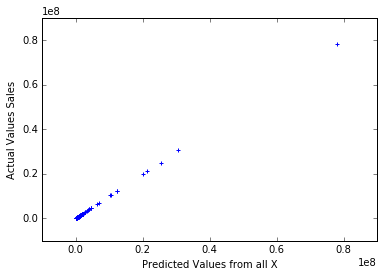

MSE: 5540410661.78
r^2: 0.999932954372
Coefficients: [  2.79693195e+00   2.68240412e+00  -1.26697955e+00   1.22887419e+05
  -8.96593959e+03  -2.67788311e-01] [-437576.06360239]


In [16]:
lm = Lasso(alpha=0.1)

X = maindf[['Bottles Sold', 'Total Markup', 'Volume Sold (Liters)','Number of Stores', 'SalesPerStore']]
y = maindf[['Sale (Dollars)']]
TestX = []
model = lm.fit(X,y)
predictions = model.predict(X)

# Plot the model
plt.scatter(predictions, y, marker='+', zorder=10)
plt.xlabel("Predicted Values from all X")
plt.ylabel("Actual Values Sales")
plt.show()
print "MSE:", mean_squared_error(y, predictions)
print "r^2:", model.score(X,y)
print "Coefficients:", model.coef_, model.intercept_

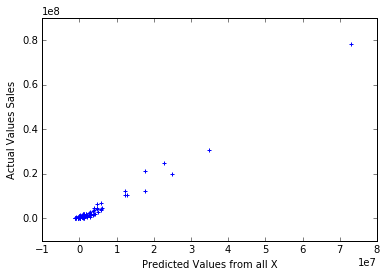

MSE: 1.98502204444e+12
r^2: 0.975978847575
Coefficients: [ 360571.28756555] [-1515941.71232739]


In [17]:
lm = Lasso(alpha=0.1)
# lm = linear_model.LinearRegression()

X = maindf[['Number of Stores']]
y = maindf[['Sale (Dollars)']]
TestX = []
model = lm.fit(X,y)
predictions = model.predict(X)

# Plot the model
plt.scatter(predictions, y, marker='+', zorder=10)
plt.xlabel("Predicted Values from all X")
plt.ylabel("Actual Values Sales")
plt.show()
print "MSE:", mean_squared_error(y, predictions)
print "r^2:", model.score(X,y)
print "Coefficients:", model.coef_, model.intercept_

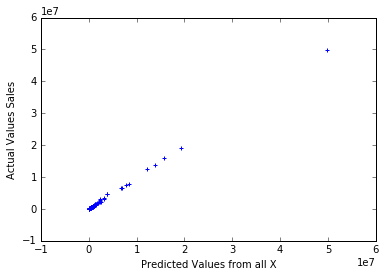

MSE: 29291295147.6
r^2: 0.999122821847
Coefficients: [[ -1.12116856e+01   2.04264991e+01  -3.95635651e+01   1.09751378e+04
    8.64595788e+03   3.66070565e+00]] [-95786.13440397]


In [72]:
lm = linear_model.LinearRegression()

X = testq12015df[['Bottles Sold', 'Total Markup', 'Volume Sold (Liters)', 'Bottle Markup','Number of Stores', 'SalesPerStore']]
y = testnotq12015df[['Sale (Dollars)']]
TestX = test2016df[['Bottles Sold']]
model = lm.fit(X,y)
predictions = model.predict(X)

# Plot the model
plt.scatter(predictions, y,  marker='+', zorder=10)
plt.xlabel("Predicted Values from all X")
plt.ylabel("Actual Values Sales")
plt.show()
print "MSE:", mean_squared_error(y, predictions)
print "r^2:", model.score(X,y)
print "Coefficients:", model.coef_, model.intercept_

In [73]:
summarydf['Sales2016'] = pd.DataFrame(predictions)
summarydf['ChangeInSales']= (summarydf['Sales2016']-summarydf['Sale (Dollars)'])
summarydf['Sales2016']= summarydf['Sales2016'].apply(lambda x: integerize(x))
summarydf['ChangeInSales']= summarydf['ChangeInSales'].apply(lambda x: integerize(x))
summarydf.head()

,County,Sale (Dollars),Bottles Sold,Total Markup,Bottle Markup,Number of Stores,Sales 2016,ChangeInSales
0,Fremont,5727.55,576,1910.32,3.316528,1,-16273,-22001
1,Davis,20775.74,1681,6934.00,4.124926,1,86278,65503
2,Adams,21834.49,1727,7293.89,4.223445,1,93997,72163
3,Wayne,22980.77,1826,7696.11,4.214737,2,93270,70289
4,Keokuk,29183.03,2730,9750.61,3.571652,3,82858,53675


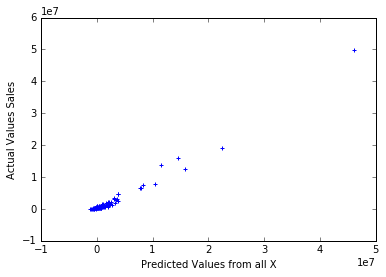

MSE: 850302259466.0
r^2: 0.974536238091
Coefficients: [[ 362547.95709155  249907.49089746]] [-2568521.69626528]


In [20]:
lm = linear_model.LinearRegression()

X = testq12015df[['Bottle Markup','Number of Stores']]
y = testnotq12015df[['Sale (Dollars)']]
TestX = test2016df[['Bottles Sold']]
model = lm.fit(X,y)
predictions = model.predict(X)

# Plot the model
plt.scatter(predictions, y,  marker='+', zorder=10)
plt.xlabel("Predicted Values from all X")
plt.ylabel("Actual Values Sales")
plt.show()
print "MSE:", mean_squared_error(y, predictions)
print "r^2:", model.score(X,y)
print "Coefficients:", model.coef_, model.intercept_

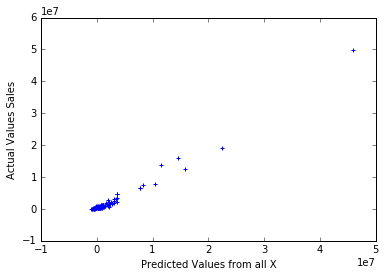

MSE: 865095164296.0
r^2: 0.974533814478
Coefficients: [[ 338885.94574559  249933.77678627]] [-2466769.16136525]


In [21]:
lm = linear_model.RidgeCV()

X = testq12015df[['Bottle Markup','Number of Stores']]
y = testnotq12015df[['Sale (Dollars)']]
TestX = test2016df[['Bottle Markup','Number of Stores']]
model = lm.fit(X,y)
predictions = model.predict(TestX)

# Plot the model
plt.scatter(predictions, y, marker='+', zorder=10)
plt.xlabel("Predicted Values from all X")
plt.ylabel("Actual Values Sales")
plt.show()
print "MSE:", mean_squared_error(y, predictions)
print "r^2:", model.score(X,y)
print "Coefficients:", model.coef_, model.intercept_

In [160]:
x = pd.DataFrame(predictions)
summarydf['Sales 2016'] = x
summarydf['ChangeInSales']=summarydf['Sales 2016']-summarydf['Sale (Dollars)']

       X Shape  Y Shape
Train (66, 2) (66, 1)
Test  (33, 2) (33, 1)
Score: 0.925185507672


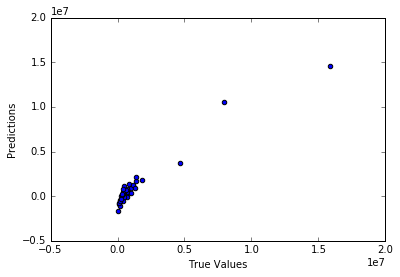

In [23]:
from sklearn.cross_validation import train_test_split

X = testq12015df[['Bottle Markup', 'Number of Stores']]
# X = testq12015df[['Bottles Sold', 'Total Markup', 'Volume Sold (Liters)', 'Bottle Markup', \
#                   'Number of Stores', 'SalesPerStore']]
y = testnotq12015df[['Sale (Dollars)']]
TestX = test2016df[['Bottle Markup', 'Number of Stores']]

X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.33)

print "       X Shape  Y Shape"
print "Train", X_train.shape, y_train.shape
print "Test ", X_test.shape, y_test.shape

lm = linear_model.LinearRegression()
# lm = linear_model.Lasso()
# lm = linear_model.RidgeCV()

model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

## The line / model
plt.scatter(y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")

print "Score:", model.score(X_test, y_test)

Cross-validated scores: [-273.51552381  -25.41634791  -72.93622995  -19.9517594    -2.13466459
    0.42631327]
Cross-Predicted R^2: 0.629816602866


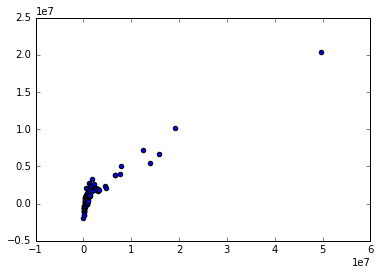

In [24]:
# Perform 6-fold cross validation
scores = cross_val_score(model, X, y, cv=6)
print "Cross-validated scores:", scores

# Make cross validated predictions
predictions = cross_val_predict(model, X, y, cv=6)
plt.scatter(y, predictions)
r2_s = r2_score(y, predictions)
print "Cross-Predicted R^2:", r2_s

In [ ]:
rects1 = plt.bar(index, means_men, bar_width,
                 alpha=opacity,
                 color='b',
                 yerr=std_men,
                 error_kw=error_config,
                 label='Men')


In [3]:
test2015df.plt(kind='bar',figsize=(16,8),x='County',y='Sale (Dollars)')

NameError: name 'test2015df' is not defined

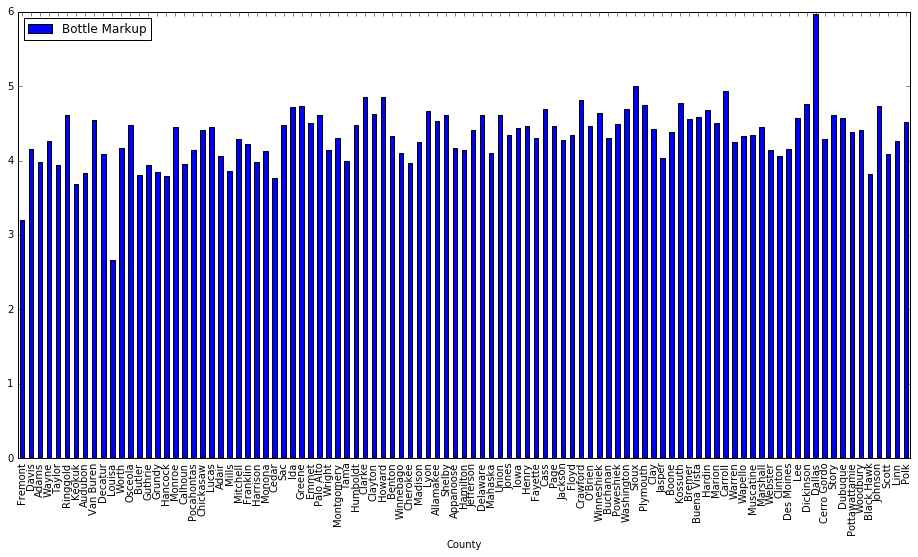

In [26]:
test2015df.plot(kind='bar',figsize=(16,8),x='County',y='Bottle Markup')

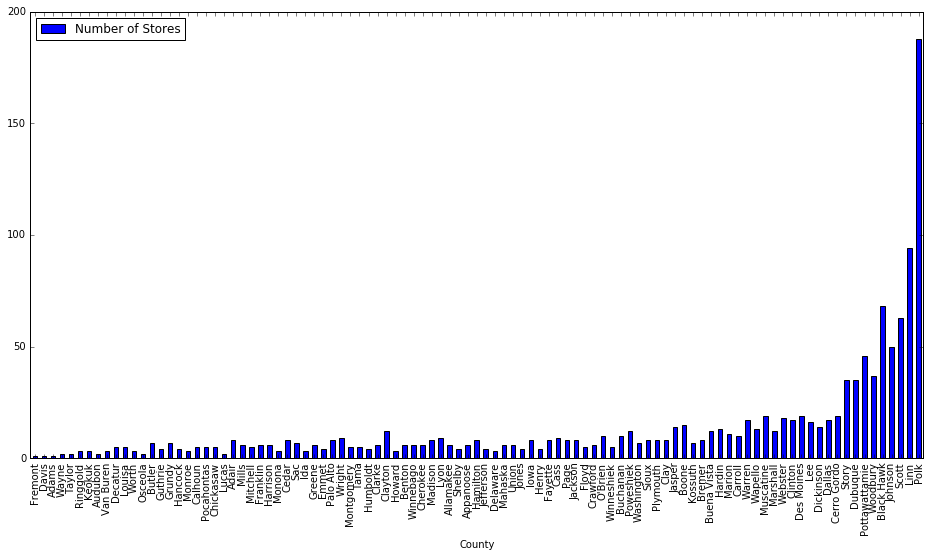

In [27]:
test2015df.plot(kind='bar',figsize=(16,8),x='County',y='Number of Stores')

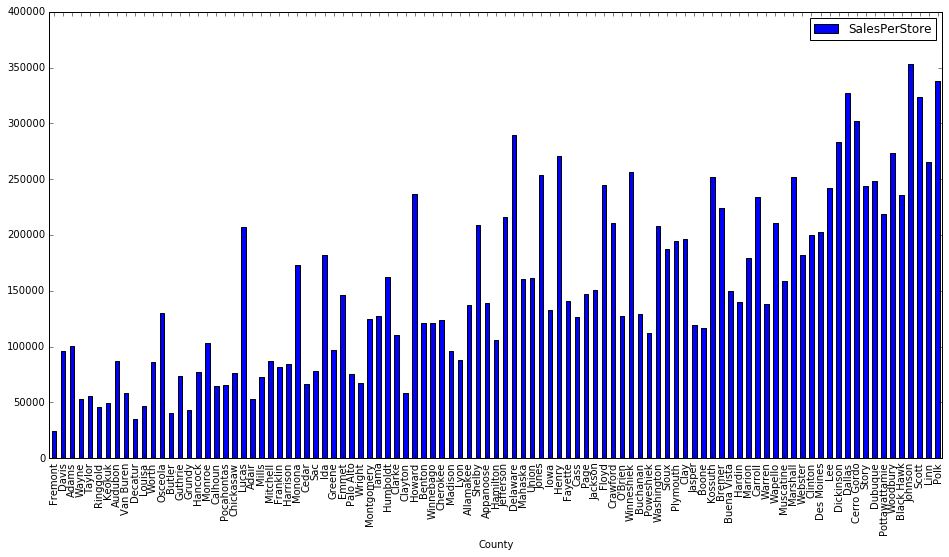

In [36]:
test2015df.plot(kind='bar',figsize=(16,8),x='County',y=('SalesPerStore'))

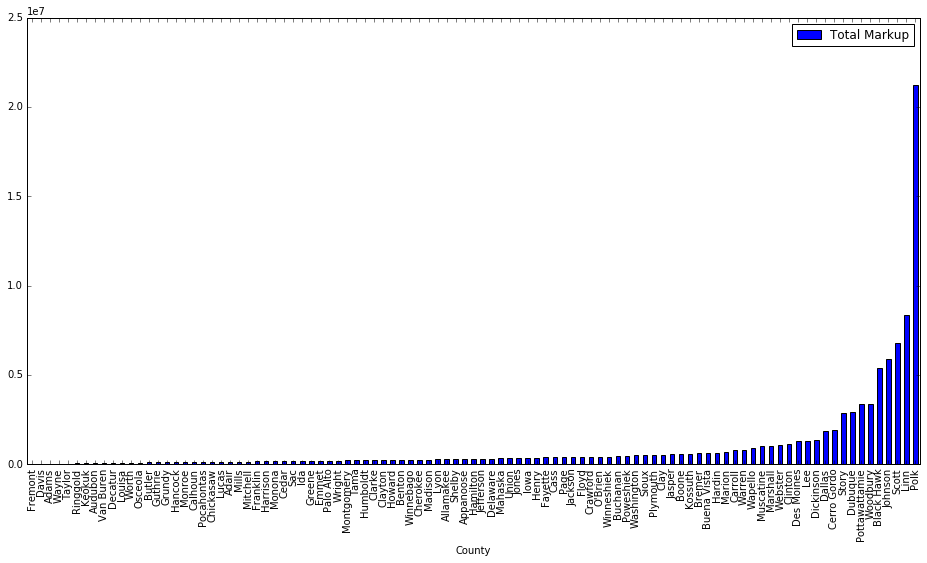

In [29]:
test2015df.plot(kind='bar',figsize=(16,8),x='County',y='Total Markup')

In [75]:
# Trying the groupby functionality just done as a trial, not needed... 
gtest1 = indexdf.groupby( ['City']).sum()
gtest1 = gtest1.sort_values(by =['Sale (Dollars)'])
# gtest1.head()

,Store Number,County Number,Vendor Number,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Total Markup
City,,,,,,,
GRISWOLD,229540,690.0,9671,239,2884.66,255.55,961.74
GILBERTVILLE,312120,420.0,14879,335,4207.66,244.81,1403.18
ROBINS,228448,2508.0,11391,332,4767.12,286.50,1594.81
DELHI,621000,3360.0,28191,721,6813.30,415.69,2276.73
LOHRVILLE,379089,949.0,16039,816,8018.97,601.55,2681.34


In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error

lm = linear_model.LinearRegression()

X = indexdf[['Volume Sold (Liters)','Bottles Sold']]
y = indexdf[['Sale (Dollars)']]
model = lm.fit(X,y)
predictions = model.predict(X)

# Plot the model
plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted Values from all X")
plt.ylabel("Actual Values Sales")
plt.show()
print "MSE:", mean_squared_error(y, predictions)

In [85]:
summarydf['CSalesPerStore'] = (summarydf['Sales 2016'] / summarydf['Number of Stores'])
summarydf['ChangeInSalesPerStore'] = summarydf['ChangeInSalesPerStore'].apply(lambda x: integerize(x))
summarydf = summarydf.sort_values(by='ChangeInSalesPerStore', ascending = False)


In [86]:
summarydf.head()

,County,Sale (Dollars),Bottles Sold,Total Markup,Bottle Markup,Number of Stores,Sales 2016,ChangeInSales,ChangeInSalesPerStore
54,Delaware,2.149173e+05,15836,7.186245e+04,4.537917,3,870679,655762,290226
95,Johnson,3.821047e+06,277110,1.275288e+06,4.602099,50,13743976,9922928,274879
98,Polk,1.450703e+07,1105511,4.842004e+06,4.379879,188,49757546,35250513,264667
96,Scott,4.531437e+06,375932,1.512052e+06,4.022143,63,15805390,11273953,250879
57,Henry,2.448760e+05,19097,8.192386e+04,4.289881,4,928620,683744,232155


In [104]:
xx = sum(testnotq12015df['Sale (Dollars)'])
print xx

220959675.81


In [108]:
yy = sum(summarydf['Sales 2016'])
print yy

220959625


In [106]:
yy-xx

-50.81002077460289

In [1]:
testnotq12015df.plot(kind='bar',figsize=(12,8),x='County',y='Sale (Dollars)')

NameError: name 'testnotq12015df' is not defined

In [2]:
summarydf.plot(kind='bar',figsize=(12,8),x='County',y='ChangeInSales')

NameError: name 'summarydf' is not defined

# Explore the data

Perform some exploratory statistical analysis and make some plots, such as histograms of transaction totals, bottles sold, etc.

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

## Record your findings

Be sure to write out anything observations from your exploratory analysis.

# Mine the data
Now you are ready to compute the variables you will use for your regression from the data. For example, you may want to
compute total sales per store from Jan to March of 2015, mean price per bottle, etc. Refer to the readme for more ideas appropriate to your scenario.

Pandas is your friend for this task. Take a look at the operations [here](http://pandas.pydata.org/pandas-docs/stable/groupby.html) for ideas on how to make the best use of pandas and feel free to search for blog and Stack Overflow posts to help you group data by certain variables and compute sums, means, etc. You may find it useful to create a new data frame to house this summary data.

# Refine the data
Look for any statistical relationships, correlations, or other relevant properties of the dataset.

# Build your models

Using scikit-learn or statsmodels, build the necessary models for your scenario. Evaluate model fit.

In [6]:
from sklearn import linear_model


## Plot your results

Again make sure that you record any valuable information. For example, in the tax scenario, did you find the sales from the first three months of the year to be a good predictor of the total sales for the year? Plot the predictions versus the true values and discuss the successes and limitations of your models

# Present the Results

Present your conclusions and results. If you have more than one interesting model feel free to include more than one along with a discussion. Use your work in this notebook to prepare your write-up.

In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
